##### Yu Han May, 2023
This script is evolved from 0.replicability to answer: 2.can you retrieve mutant for the same wild type from the wild type itself. Specifically, protein channel features are seperated from non-protein features. Plot is generated to compare mAP score to CC score. 

In [1]:
import pandas as pd
import numpy as np
from copairs.map import aggregate
from copairs.map import run_pipeline
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
#read profile
df_p1=pd.read_csv('../../varchamp_profiles/2023_02_23_Batch_3/2022_10_11_PPL9_P1/2022_10_11_PPL9_P1_normalized_feature_select_batch.csv.gz')
df_p2=pd.read_csv('../../varchamp_profiles/2023_02_23_Batch_3/2022_09_29_PPL9_P2/2022_09_29_PPL9_P2_normalized_feature_select_batch.csv.gz')
df_p3=pd.read_csv('../../varchamp_profiles/2023_02_23_Batch_3/2022_09_29_PPL9_P3/2022_09_29_PPL9_P3_normalized_feature_select_batch.csv.gz')
#read metadata
df_metadata=pd.read_csv('../../varchamp_profiles/2023_02_23_Batch_3.csv')
df_metadata.head(2)

,Metadata_Well,384_ID,entryID,Symbol,entry_plate.x,entry_well.x,entry_numb,dest_plate_96,dest_well_96,dest_numb_96,...,r384,c384,Metadata_Plate,batch,control,Gene,MT,Variant,Metadata_Sample_Unique,Metadata_batch_Plate
0,A01,1_1,DisWTGDEh03_F06,ACSF3,DisWTGDEh03,F06,46.0,FVrry_P01_Q01,A01,1.0,...,1.0,1.0,2022_10_11_PPL9_P1,2023_02_23_Batch_3,False,ACSF3,NaN,ACSF3,ACSF3,2023_02_23_Batch_3-2022_10_11_PPL9_P1
1,C01,3_1,VUSmut_GDEh03_A02,ACSF3,VUSmut_GDEh03,A02,9.0,FVrry_P01_Q01,B01,2.0,...,3.0,1.0,2022_10_11_PPL9_P1,2023_02_23_Batch_3,False,ACSF3,Ala197Thr,ACSF3 Ala197Thr,ACSF3 Ala197Thr,2023_02_23_Batch_3-2022_10_11_PPL9_P1


In [3]:
#read CC score into dataframe
df_cc=pd.read_csv('../../varchamp_profiles/impact_scores_perplate_20230410.csv')
#extract cc_p and cc_np columns
df_cc=df_cc[['Metadata_Sample_Unique','cc_p','cc_np']]
#get the mean score for cc_p and cc_np columns based on Metadata_Sample_Unique
df_cc_mean=df_cc.groupby('Metadata_Sample_Unique').mean()
#make Metadata_Sample_Unique as a column
df_cc_mean.reset_index(inplace=True)
df_cc_mean.head(2)

,Metadata_Sample_Unique,cc_p,cc_np
0,ACSF3 Ala197Thr,-0.220456,0.460932
1,ACSF3 Arg10Trp,0.176881,0.448367


In [4]:
#concatenate df_p1, df_p2, df_p3
df=pd.concat([df_p1,df_p2,df_p3],axis=0)
#remove Metadata_Symbol=516-TC in df
df_profile=df[df['Metadata_Symbol']!='516 - TC']
df_profile.head(2)

,Metadata_384_ID,Metadata_entryID,Metadata_Symbol,Metadata_entry_plate.x,Metadata_entry_well.x,Metadata_entry_numb,Metadata_dest_plate_96,Metadata_dest_well_96,Metadata_dest_numb_96,Metadata_orf_id,...,Nuclei_Texture_SumEntropy_DNA_20_01_256,Nuclei_Texture_SumEntropy_DNA_20_02_256,Nuclei_Texture_SumEntropy_DNA_20_03_256,Nuclei_Texture_SumVariance_AGP_20_02_256,Nuclei_Texture_SumVariance_DNA_20_01_256,Nuclei_Texture_SumVariance_DNA_20_02_256,Nuclei_Texture_SumVariance_DNA_20_03_256,Nuclei_Texture_SumVariance_GFP_5_01_256,Nuclei_Texture_SumVariance_Mito_20_03_256,Nuclei_Texture_Variance_AGP_10_00_256
0,1_1,DisWTGDEh03_F06,ACSF3,DisWTGDEh03,F06,46.0,FVrry_P01_Q01,A01,1.0,71337.0,...,-1.6834,-1.84680,-1.56960,-0.43763,-1.05170,-1.06410,-0.99208,-0.59723,0.94397,-0.54754
1,3_1,VUSmut_GDEh03_A02,ACSF3,VUSmut_GDEh03,A02,9.0,FVrry_P01_Q01,B01,2.0,71337.0,...,0.1716,0.42315,0.38591,-0.64088,0.37808,0.38868,1.27990,-0.65973,4.86160,-0.73677


In [5]:
#merge Gene, MT, and Metadata_Sample_Unique from df_metadata to df_profile 
#based on columns of Metadata_Well and Metadata_Plate
df_merge=df_profile.merge(df_metadata[['Metadata_Well','Metadata_Plate','Gene','MT','Metadata_Sample_Unique']],on=['Metadata_Well','Metadata_Plate'],how='left')
#change Gene to Metadata_Gene and MT to Metadata_MT
df_merge.rename(columns={'Gene':'Metadata_Gene','MT':'Metadata_MT'},inplace=True)
#add a column of Metadata_type where if Metadata_MT is NaN, Metadata_type is 'WT', otherwise 'MT'
df_merge['Metadata_type']=np.where(df_merge['Metadata_MT'].isnull(),'WT','MT')
df_merge.head(2)

,Metadata_384_ID,Metadata_entryID,Metadata_Symbol,Metadata_entry_plate.x,Metadata_entry_well.x,Metadata_entry_numb,Metadata_dest_plate_96,Metadata_dest_well_96,Metadata_dest_numb_96,Metadata_orf_id,...,Nuclei_Texture_SumVariance_DNA_20_01_256,Nuclei_Texture_SumVariance_DNA_20_02_256,Nuclei_Texture_SumVariance_DNA_20_03_256,Nuclei_Texture_SumVariance_GFP_5_01_256,Nuclei_Texture_SumVariance_Mito_20_03_256,Nuclei_Texture_Variance_AGP_10_00_256,Metadata_Gene,Metadata_MT,Metadata_Sample_Unique,Metadata_type
0,1_1,DisWTGDEh03_F06,ACSF3,DisWTGDEh03,F06,46.0,FVrry_P01_Q01,A01,1.0,71337.0,...,-1.05170,-1.06410,-0.99208,-0.59723,0.94397,-0.54754,ACSF3,NaN,ACSF3,WT
1,3_1,VUSmut_GDEh03_A02,ACSF3,VUSmut_GDEh03,A02,9.0,FVrry_P01_Q01,B01,2.0,71337.0,...,0.37808,0.38868,1.27990,-0.65973,4.86160,-0.73677,ACSF3,Ala197Thr,ACSF3 Ala197Thr,MT


In [6]:
#extract meta and feat columns
meta_cols = [c for c in df_merge.columns if c.startswith('Meta')]
feat_cols = [c for c in df_merge.columns if not c.startswith('Meta')]
#select protein channel features, where GFP exists in feat_cols
feat_cols_protein=[c for c in feat_cols if 'GFP' in c]
#select non-protein channel features, where GFP does not exist in feat_cols
feat_cols_non_protein=[c for c in feat_cols if 'GFP' not in c]

In [7]:
meta = df_merge[meta_cols]
feats_protein = df_merge[feat_cols_protein].values
feats_non_protein = df_merge[feat_cols_non_protein].values

#### retrieve mutants from its WT, protein channel

In [8]:
pos_sameby = ['Metadata_Gene']
pos_diffby = ['Metadata_type']
neg_sameby = []
neg_diffby = ['Metadata_Gene']
null_size = 10000

In [9]:
bio_result = run_pipeline(meta, feats_protein, pos_sameby, pos_diffby, neg_sameby, neg_diffby, null_size)
#remove Metadata_type=WT
bio_result=bio_result[bio_result['Metadata_type']!='WT']
bio_result_agg=aggregate(bio_result, 'Metadata_Sample_Unique', threshold=0.05)
bio_result_agg[['above_p_threshold', 'above_q_threshold']].value_counts()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

above_p_threshold  above_q_threshold
False              False                131
True               True                  90
                   False                 33
Name: count, dtype: int64

In [10]:
#missing Metadata_Sample_Unique in df_cc_mean comparing to bio_result_agg
lista=list(bio_result_agg['Metadata_Sample_Unique'])
listb=list(df_cc_mean['Metadata_Sample_Unique'])
list_diff=list(set(lista).difference(set(listb)))
list_diff


['CTH Gln240Glu',
 'BLMH Ile443Val',
 'AP2S1 Arg15Cys',
 'CLDN19 Arg200Gln',
 'CUL3 Lys459Arg',
 'CTNNA3 Val94Asp',
 'AP2S1 Arg15His',
 'BLK Ala71Thr',
 'CCBE1 Gly136Arg',
 'CLDN19 Gln57Glu',
 'CTH Thr67Ile',
 'CTH Ser403Ile']

In [11]:
#merge bio_result_agg with df_cc_mean based on Metadata_Sample_Unique
df_merge_cc=df_cc_mean.merge(bio_result_agg,on='Metadata_Sample_Unique',how='left')
df_merge_cc.head(2)

,Metadata_Sample_Unique,cc_p,cc_np,average_precision,nlog10pvalue,q_value,nlog10qvalue,above_p_threshold,above_q_threshold
0,ACSF3 Ala197Thr,-0.220456,0.460932,0.003251,0.131854,0.847669,0.071774,False,False
1,ACSF3 Arg10Trp,0.176881,0.448367,0.006241,0.446405,0.493868,0.306389,False,False


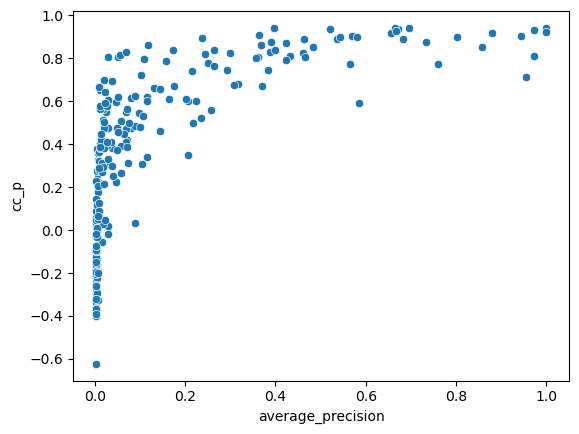

In [12]:
#plot mAP score vs cc_p scoren using sns
sns.scatterplot(data=df_merge_cc, x="average_precision", y="cc_p")
plt.show()

#### retrieve mutants from its WT, non protein channel

In [13]:
bio_result_non = run_pipeline(meta, feats_non_protein, pos_sameby, pos_diffby, neg_sameby, neg_diffby, null_size)
#remove Metadata_type=WT
bio_result_non=bio_result_non[bio_result_non['Metadata_type']!='WT']
bio_result_agg_non=aggregate(bio_result_non, 'Metadata_Sample_Unique', threshold=0.05)
bio_result_agg_non[['above_p_threshold', 'above_q_threshold']].value_counts()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

above_p_threshold  above_q_threshold
False              False                187
True               True                  34
                   False                 33
Name: count, dtype: int64

In [14]:
#merge bio_result_agg with df_cc_mean based on Metadata_Sample_Unique
df_merge_cc_non=df_cc_mean.merge(bio_result_agg_non,on='Metadata_Sample_Unique',how='left')
df_merge_cc_non.head(2)

,Metadata_Sample_Unique,cc_p,cc_np,average_precision,nlog10pvalue,q_value,nlog10qvalue,above_p_threshold,above_q_threshold
0,ACSF3 Ala197Thr,-0.220456,0.460932,0.018725,0.891301,0.299565,0.523509,False,False
1,ACSF3 Arg10Trp,0.176881,0.448367,0.020284,1.128245,0.236319,0.626501,False,False


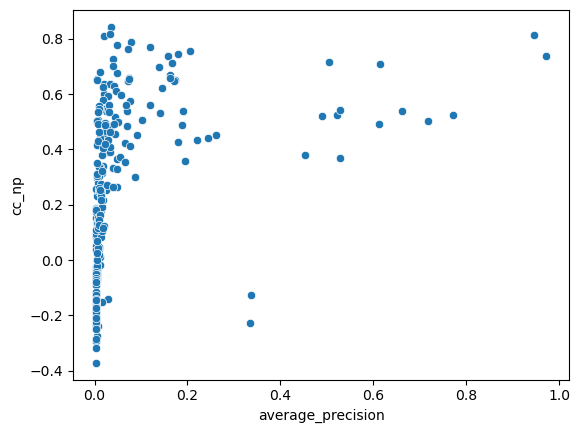

In [15]:
#plot mAP score vs cc_p scoren using sns
sns.scatterplot(data=df_merge_cc_non, x="average_precision", y="cc_np")
plt.show()